# MASK DETECTION USING YOLO v5


Custom training of the YOLO model performed by using the data available at https://www.kaggle.com/andrewmvd/face-mask-detection.

853 png images with annotations is available for train,validation and test of the model

### 1. LOADING THE DATA

In [ ]:
!unzip data.zip

In [4]:
import os

path = 'data/'
annotations_path = path + 'annotations/'
images_path = path + 'images/'

annotations_files = [something for something in os.listdir(annotations_path) if not os.path.isdir(annotations_path + something)]
images_files = [something for something in os.listdir(images_path) if not os.path.isdir(images_path + something)]

In [5]:
import re

annotations_files.sort(key = lambda e: int(re.sub('[^0-9]', '', e)))
images_files.sort(key = lambda e: int(re.sub('[^0-9]', '', e)))

In [6]:
pwd = !pwd # ['/working']
pwd = pwd[0] + '/'

dataset_path = pwd + 'datasets/facemask/'
if not os.path.isdir(dataset_path):
    !mkdir -p {dataset_path}

new_images_path = dataset_path + 'images/'
new_labels_path = dataset_path + 'labels/'

if not os.path.isdir(new_images_path):
    !cp -rf {images_path} {dataset_path}
if not os.path.isdir(new_labels_path):
    !mkdir -p {new_labels_path}
!ls {dataset_path}

images	labels


In [7]:
def get_yolo_format(pic_width, pic_height, x_min, y_min, x_max, y_max):
    x_center = (x_max + x_min) / (2 * pic_width)
    y_center = (y_max + y_min) / (2 * pic_height)
    width = (x_max - x_min) / pic_width
    height = (y_max - y_min) / pic_height
    return x_center, y_center, width, height

In [8]:
import xml.etree.ElementTree as ET

labels = ['with_mask', 'mask_weared_incorrect', 'without_mask']
infos = [] # used <5. Compare images>

for annotations_file in annotations_files:
    label_file_name = annotations_file.split('.')[0] + '.txt'
    with open(new_labels_path + label_file_name, 'w') as label_file:
        root = ET.parse(annotations_path + annotations_file)
        pic_width = int(root.find('size').findtext('width'))
        pic_height = int(root.find('size').findtext('height'))
        info = [pic_width, pic_height]
        for obj in root.findall('object'):
            box_info = []
            class_name = obj.findtext('name')
            x_min = int(obj.find('bndbox').findtext('xmin'))
            y_min = int(obj.find('bndbox').findtext('ymin'))
            x_max = int(obj.find('bndbox').findtext('xmax'))
            y_max = int(obj.find('bndbox').findtext('ymax'))
            info.append([labels.index(class_name), x_min, y_min, x_max, y_max])
            yolo_format = get_yolo_format(pic_width, pic_height, x_min, y_min, x_max, y_max)
            label_file.write(str(labels.index(class_name)) + ' ' + ' '.join(map(str, yolo_format)) + '\n')
        infos.append(info)
        label_file.flush()

In [9]:
labels_files = [something for something in os.listdir(new_labels_path) if not os.path.isdir(new_labels_path + something)]
labels_files.sort(key = lambda e: int(re.sub('[^0-9]', '', e)))

In [10]:
!cat {new_labels_path}{labels_files[0]}

2 0.18359375 0.337431693989071 0.05859375 0.10109289617486339
0 0.4013671875 0.3333333333333333 0.080078125 0.12021857923497267
2 0.6689453125 0.3155737704918033 0.068359375 0.13934426229508196


### 2. TRAIN, TEST, VALIDATION SPLIT

In [11]:
from sklearn.model_selection import train_test_split

show_count = 5 # used <5. Compare images>
images_train, images_else, labels_train, labels_else = train_test_split(images_files, labels_files, test_size = 0.2)
images_val, images_test, labels_val, labels_test = train_test_split(images_else, labels_else, test_size = show_count / len(images_else))

len(images_train), len(images_val), len(images_test)

(682, 166, 5)

In [12]:
sub_directories = ['train/', 'val/', 'test/']
for sub_directory in sub_directories:
    if not os.path.isdir(new_images_path + sub_directory):
        !mkdir {new_images_path}{sub_directory}
    if not os.path.isdir(new_labels_path + sub_directory):
        !mkdir {new_labels_path}{sub_directory}
        
# move from all data to train
!mv {new_images_path}{images_files[0].split('.')[0][:-1]}* {new_images_path}train
!mv {new_labels_path}{labels_files[0].split('.')[0][:-1]}* {new_labels_path}train

In [13]:
def move_data(source_directory, source_files, target_directory):
    for source_file in source_files:
        !mv {source_directory}{source_file} {target_directory}{source_file}

In [14]:
# Move from train to validation and test

images_files_list = [images_val, images_test]
labels_files_list = [labels_val, labels_test]

for images_files, labels_files, sub_directory in zip(images_files_list, labels_files_list, sub_directories[1:]):
    move_data(new_images_path + sub_directories[0], images_files, new_images_path + sub_directory)
    move_data(new_labels_path + sub_directories[0], labels_files, new_labels_path + sub_directory)

In [15]:
import yaml

yaml_file = pwd + 'config.yaml'

yaml_data = dict(
    path = new_images_path,
    train = (new_images_path + sub_directories[0])[:-1],
    val = (new_images_path + sub_directories[1])[:-1],
    nc = len(labels),
    names = labels
)

with open(yaml_file, 'w') as f:
    yaml.dump(yaml_data, f, explicit_start = True, default_flow_style = False)

In [20]:
%%writefile {yaml_file}

path: /content/datasets/facemask/images/
train: /content/datasets/facemask/images/train
val: /content/datasets/facemask/images/val
nc: 3
names: ['with_mask', 'mask_weared_incorrect', 'without_mask']

Overwriting /content/config.yaml


### 3. TRAINING THE YOLO v5 MODEL

In [17]:
yolo_path = pwd + 'yolov5/'
if not os.path.isdir(yolo_path):
    !git clone https://github.com/ultralytics/yolov5.git
!pip3 install -qr {yolo_path}requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 9928, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 9928 (delta 15), reused 13 (delta 5), pack-reused 9890
Receiving objects: 100% (9928/9928), 10.31 MiB | 4.79 MiB/s, done.
Resolving deltas: 100% (6874/6874), done.
     |████████████████████████████████| 596 kB 5.7 MB/s 


In [18]:
import torch

model_name = 'yolov5l'
image_size = 640
batch_size = 16
epochs = 10
device = '0' if torch.cuda.is_available() else 'cpu'
saved_model_name = 'best.pt'

# for test
confidence_threshold = 0.25 # Threshold of object inference
iou_threshold = 0.45 # Threshold of remove overlapping boxes

device

'0'

In [21]:
!python3 {yolo_path}train.py --weights {model_name}.pt \
        --cfg {yolo_path}models/{model_name}.yaml --data {yaml_file} \
        --hyp {yolo_path}data/hyps/hyp.scratch.yaml --epochs {epochs} --batch-size {batch_size} \
        --img-size {image_size} --device {device}

train: weights=yolov5l.pt, cfg=/content/yolov5/models/yolov5l.yaml, data=/content/config.yaml, hyp=/content/yolov5/data/hyps/hyp.scratch.yaml, epochs=10, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=0, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=yolov5/runs/train, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=0, save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.0-89-g540ef0d torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015

In [31]:
saved_model = 'yolov5/runs/train/exp2/weights/' + saved_model_name
submission_path = pwd + 'submission/'
if not os.path.isdir(submission_path):
    !mkdir {submission_path}
!mv {saved_model} {submission_path}{saved_model_name}
!rm -rf {pwd}runs/train/*
!ls {submission_path}

best.pt


### 4. TESTING WITH A FEW SAMPLE IMAGES 

In [32]:
!python3 {yolo_path}detect.py --weights {submission_path}{saved_model_name} \
        --source {new_images_path + sub_directories[2]} --img-size {image_size} \
        --conf-thres {confidence_threshold} --iou-thres {iou_threshold} --device {device} \
        --hide-labels --hide-conf

detect: weights=['/content/submission/best.pt'], source=/content/datasets/facemask/images/test/, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=True, hide_conf=True, half=False, dnn=False
YOLOv5 🚀 v6.0-89-g540ef0d torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

Fusing layers... 
Model Summary: 367 layers, 46119048 parameters, 0 gradients, 107.8 GFLOPs
image 1/5 /content/datasets/facemask/images/test/maksssksksss170.png: 384x640 1 with_mask, Done. (0.103s)
image 2/5 /content/datasets/facemask/images/test/maksssksksss318.png: 384x640 7 with_masks, 2 without_masks, Done. (0.091s)
image 3/5 /content/datasets/facemask/images/test/maksssksksss465.png: 480x640 1 with_mask, Done. (0.111s)
image 4/5 /content/datasets/facemask/

In [34]:
!cp yolov5/runs/detect/exp2/* {submission_path}
# !rm -rf yolov5/runs/detect/*
predict_images = [something for something in os.listdir(submission_path) if not os.path.isdir(submission_path + something) and something.endswith('.png')]
predict_images.sort(key = lambda e: int(re.sub('[^0-9]', '', e)))
predict_images

['maksssksksss49.png',
 'maksssksksss170.png',
 'maksssksksss318.png',
 'maksssksksss465.png',
 'maksssksksss650.png']

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

TEST SCRIPT

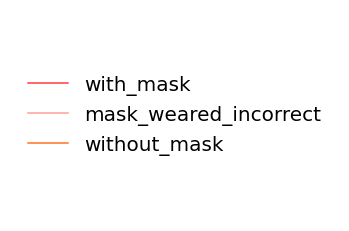

In [37]:

import matplotlib.pyplot as plt

# Colors in the same order as yolov5 (yolov5/utils/plots.py -> colors)
colors = ['#FF3838', '#FF9D97', '#FF701F']

for c, l in zip(colors, labels):
    plt.plot(0, 0, c, label = l)
plt.legend(fontsize = 20, loc = 'center', frameon = False)
plt.axis('off')
plt.show()

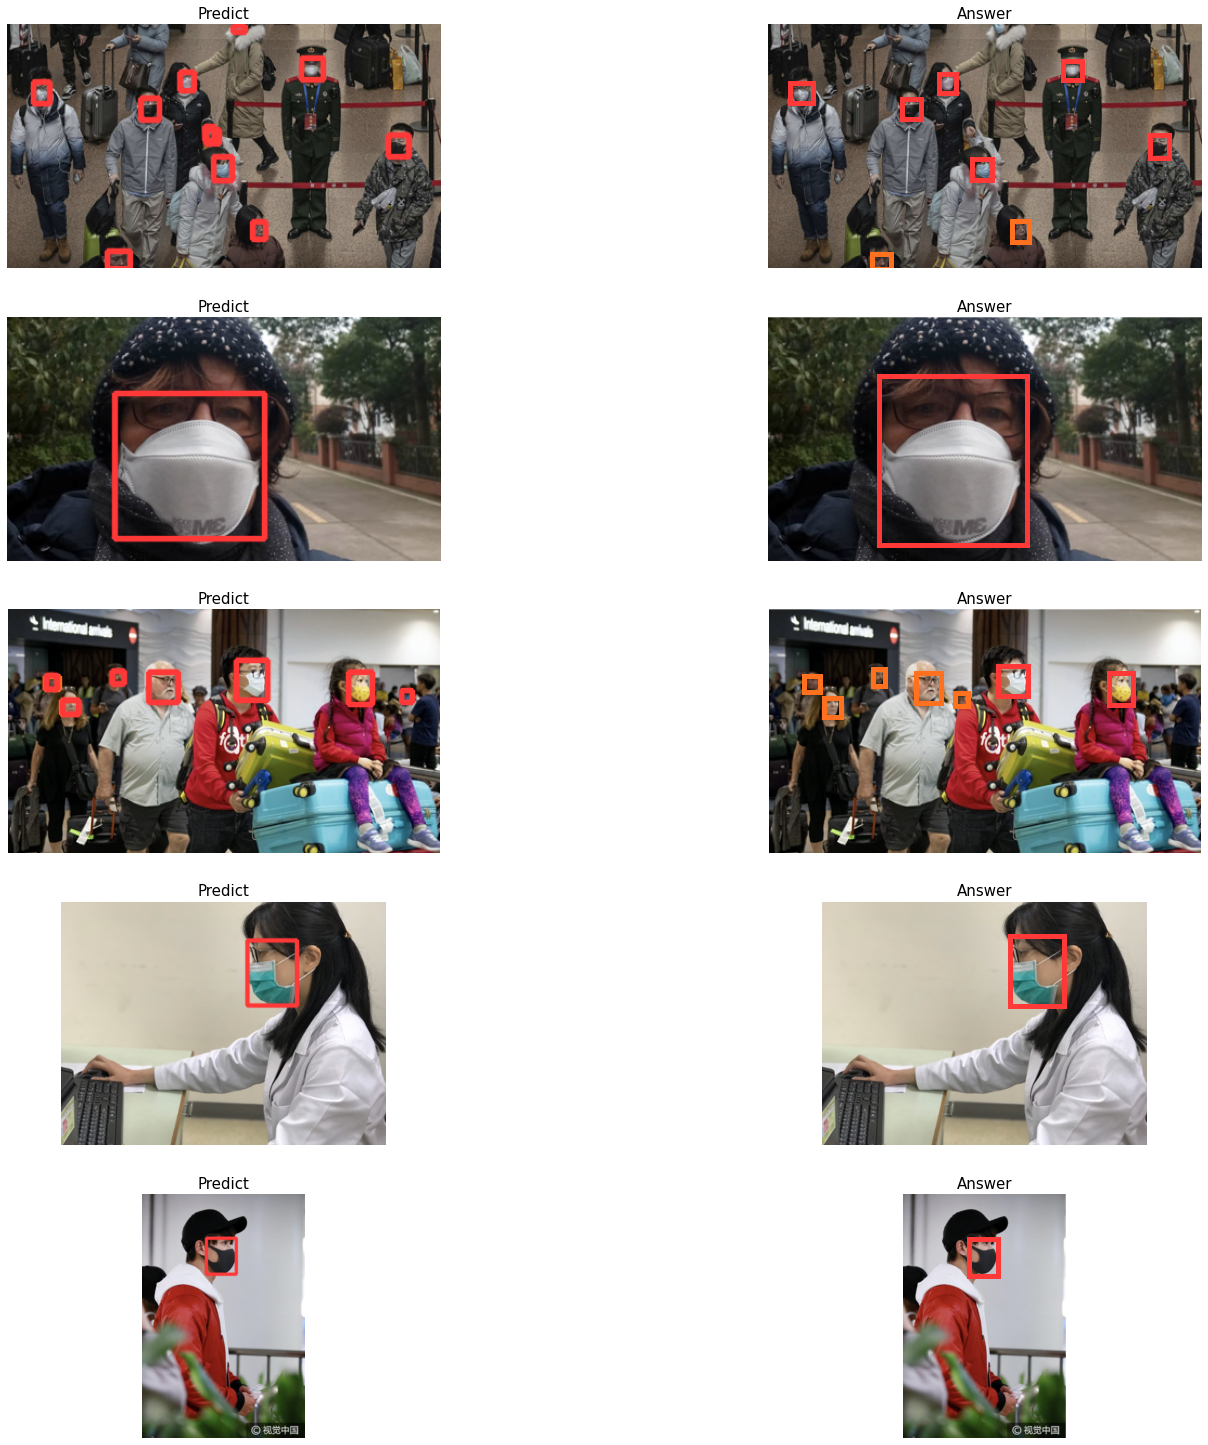

In [39]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

predict_show_list = random.sample(predict_images, show_count)

row = show_count
col = 2
figure = plt.figure(figsize = (5 * row, 13 * col))

for r, image_name in zip(range(row), predict_images):
    for c in range(col):
        if c == 0:   # Predict image
            image_path = submission_path
            title = 'Predict'
        elif c == 1: # Answer image
            image_path = images_path
            title = 'Answer'
        ax = figure.add_subplot(row, col, r * col + c + 1)
        ax.imshow(mpimg.imread(image_path + image_name))
        if c == 1:   # Draw rectangle for answer image.
            for box in infos[int(re.sub('[^0-9]', '', image_name))][2:]:
                l, x1, y1, x2, y2 = box
                ax.add_patch(matplotlib.patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth = 5, color = colors[l], fill = False))
        ax.set_title(title, fontsize = 15)
        ax.axis("off")
plt.show()

In [ ]:
!zip -r yolov5.zip ../content/ 